## Проект 5. Выбираем авто выгодно

Задачу в рамках проекта можно разбить на 3 основных этапа:
1. Сбор базы данных
2. Проведение EDA и отбор подходящих признаков
3. Подбор подходящих алгоритмов и обучение модели

Начнем, естественно, с первого :) Его тоже можно разбить на небольшие подзадачи:
1. Выбрать источник данных
2. Разобраться, как корректно добавлять данные в датасет из одной страницы
3. Разобраться, как перебирать страницы
2. Перебрать страницы и собрать данные в датасет
    
Если сбор датасета превратится в серьезную проблему, попробуем найти готовый. Итак, поехали.

### Сбор данных

In [95]:
# Для начала импортируем нужные библиотеки
import pandas as pd
from pandas import Series
import numpy as np
import json
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import missingno as msno
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor

In [97]:
RANDOM_SEED = 42
VERSION    = 11
DIR_TRAIN  = '../input/sf-autoru-solve-v4/' # подключил к ноутбуку свой внешний датасет
DIR_TEST   = '../input/sf-dst-car-price/'
VAL_SIZE   = 0.33   # 33%
N_FOLDS    = 5

# CATBOOST
ITERATIONS = 2000
LR         = 0.1

In [43]:
# Целевым сайтом для "охоты на данные" выбран auto.ru
# Сначала я написал функцию, которая неплохо парсила отдельные страницы auto.ru, 
# но затем встал вопрос - а как получить несколько десятков тысяч таких страниц?

# В итоге наткнулся на почти готовое решение - https://github.com/DarkLabel1/YouTube/blob/master/Auto_ru.py.
# Огромное спасибо автору - при наличии такого парсера велосипед изобретать бессмысленно, и я просто адаптировал этот код для нашей задачи

# Сначала получим нужный токен для парсинга

# Импортируем нужные библиотеки
import requests
import pandas as pd
import numpy as np

# Находим на странице https://auto.ru токен, который нужен для парсинга
ses = requests.Session()
ses.get('https://auto.ru')  
csrf_token = ses.cookies.get("_csrf_token")

count = 0 #счетчик для определения размера базы
cars_list = []
regions_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28] # Возьмем данные по 
#нескольким регионам
for region in regions_list:
    a = 1
    while a <= 99: #Возьмем 99 страниц на сайте
    
        url = 'https://auto.ru/-/ajax/desktop/listing/' #URL на который будет отправлен запрос

        #Параметры запроса
        params = {
         'section': "all",
         'category': "cars",
         'geo_id' : region, 
         'page': a
        }
        #Заголовки страницы
        headers = {"x-csrf-token": csrf_token}

        response = ses.post(url, json=params, headers=headers) #Делаем post запрос на url
        data = response.json()['offers'] #Переменная data хранит полученные объявления

        i = 0 #Переменная для перехода по объявлениям
        while i <= len(data) - 1: #len(data)-1 это количество пришедших объявлений
            items_list = []
            
            #id
            try: 
                items_list.append(data[i]['id'])
            except: 
                items_list.append(np.NaN)
            
            #Body_type
            try:
                items_list.append(data[i]['vehicle_info']['configuration']['body_type'])
            except: 
                items_list.append(np.NaN)
                
            #Brand    
            try:
                items_list.append(data[i]['vehicle_info']['mark_info']['name'])
            except: 
                items_list.append(np.NaN)
            
            #Color
            try:
                items_list.append(data[i]['color_hex'])
            except: 
                items_list.append(np.NaN)
                
            #engineDisplacement
            try:
                items_list.append(data[i]['lk_summary'])
            except: 
                items_list.append(np.NaN)
            
            #enginePower
            try:
                items_list.append(data[i]['owner_expenses']['transport_tax']['horse_power'])
            except: 
                items_list.append(np.NaN)
            
            #fuelType
            try:
                items_list.append(data[i]['vehicle_info']['tech_param']['engine_type'])
            except: 
                items_list.append(np.NaN)
                
            #mileage
            try:
                items_list.append(data[i]['state']['mileage'])
            except: 
                items_list.append(np.NaN)
            
            #name
            try:
                items_list.append(data[i]['vehicle_info']['model_info']['name'])
            except: 
                items_list.append(np.NaN)
                
            #numberOfDoors
            try:
                items_list.append(data[i]['vehicle_info']['configuration']['doors_count'])
            except: 
                items_list.append(np.NaN)
                
            #productionDate
            try:
                items_list.append(data[i]['documents']['year'])
            except: 
                items_list.append(np.NaN)
            
            #vehicleTransmission
            try:
                items_list.append(data[i]['vehicle_info']['tech_param']['transmission'])
            except: 
                items_list.append(np.NaN)
             
            #Владельцы   
            try:  
                items_list.append(data[i]['documents']['owners_number'])
            except: 
                items_list.append(np.NaN)
                
            #ПТС 
            try:   
                items_list.append(data[i]['documents']['pts'])
            except: 
                items_list.append(np.NaN)
                
            #Привод    
            try:
                items_list.append(data[i]['vehicle_info']['tech_param']['gear_type'])
            except: 
                items_list.append(np.NaN)
                
            #Руль
            try:
                items_list.append(data[i]['vehicle_info']['steering_wheel'])
            except: 
                items_list.append(np.NaN)
            
            #Price
            try:
                items_list.append(data[i]['price_info']['RUR'])
            except: 
                items_list.append(np.NaN) 
            

            i += 1 #Увеличиваем переменную перехода по объявлениям на 1
            count += 1
            cars_list.append(items_list)
        print('Page: ' + str(a)) #Выводим сообщение, какая страница записалась
        a += 1 #Увеличиваем переменную страницы сайта на 1
    
print('Successfully') #Выводим информацию об успешном выполнении
print('Размер базы:',count) #Выведем размер получившейся базы
        

Page: 1
Page: 2
Page: 3
Page: 4
Page: 5
Page: 6
Page: 7
Page: 8
Page: 9
Page: 10
Page: 11
Page: 12
Page: 13
Page: 14
Page: 15
Page: 16
Page: 17
Page: 18
Page: 19
Page: 20
Page: 21
Page: 22
Page: 23
Page: 24
Page: 25
Page: 26
Page: 27
Page: 28
Page: 29
Page: 30
Page: 31
Page: 32
Page: 33
Page: 34
Page: 35
Page: 36
Page: 37
Page: 38
Page: 39
Page: 40
Page: 41
Page: 42
Page: 43
Page: 44
Page: 45
Page: 46
Page: 47
Page: 48
Page: 49
Page: 50
Page: 51
Page: 52
Page: 53
Page: 54
Page: 55
Page: 56
Page: 57
Page: 58
Page: 59
Page: 60
Page: 61
Page: 62
Page: 63
Page: 64
Page: 65
Page: 66
Page: 67
Page: 68
Page: 69
Page: 70
Page: 71
Page: 72
Page: 73
Page: 74
Page: 75
Page: 76
Page: 77
Page: 78
Page: 79
Page: 80
Page: 81
Page: 82
Page: 83
Page: 84
Page: 85
Page: 86
Page: 87
Page: 88
Page: 89
Page: 90
Page: 91
Page: 92
Page: 93
Page: 94
Page: 95
Page: 96
Page: 97
Page: 98
Page: 99
Page: 1
Page: 2
Page: 3
Page: 4
Page: 5
Page: 6
Page: 7
Page: 8
Page: 9
Page: 10
Page: 11
Page: 12
Page: 13
Page: 14
P

Page: 31
Page: 32
Page: 33
Page: 34
Page: 35
Page: 36
Page: 37
Page: 38
Page: 39
Page: 40
Page: 41
Page: 42
Page: 43
Page: 44
Page: 45
Page: 46
Page: 47
Page: 48
Page: 49
Page: 50
Page: 51
Page: 52
Page: 53
Page: 54
Page: 55
Page: 56
Page: 57
Page: 58
Page: 59
Page: 60
Page: 61
Page: 62
Page: 63
Page: 64
Page: 65
Page: 66
Page: 67
Page: 68
Page: 69
Page: 70
Page: 71
Page: 72
Page: 73
Page: 74
Page: 75
Page: 76
Page: 77
Page: 78
Page: 79
Page: 80
Page: 81
Page: 82
Page: 83
Page: 84
Page: 85
Page: 86
Page: 87
Page: 88
Page: 89
Page: 90
Page: 91
Page: 92
Page: 93
Page: 94
Page: 95
Page: 96
Page: 97
Page: 98
Page: 99
Page: 1
Page: 2
Page: 3
Page: 4
Page: 5
Page: 6
Page: 7
Page: 8
Page: 9
Page: 10
Page: 11
Page: 12
Page: 13
Page: 14
Page: 15
Page: 16
Page: 17
Page: 18
Page: 19
Page: 20
Page: 21
Page: 22
Page: 23
Page: 24
Page: 25
Page: 26
Page: 27
Page: 28
Page: 29
Page: 30
Page: 31
Page: 32
Page: 33
Page: 34
Page: 35
Page: 36
Page: 37
Page: 38
Page: 39
Page: 40
Page: 41
Page: 42
Page: 43
P

Page: 61
Page: 62
Page: 63
Page: 64
Page: 65
Page: 66
Page: 67
Page: 68
Page: 69
Page: 70
Page: 71
Page: 72
Page: 73
Page: 74
Page: 75
Page: 76
Page: 77
Page: 78
Page: 79
Page: 80
Page: 81
Page: 82
Page: 83
Page: 84
Page: 85
Page: 86
Page: 87
Page: 88
Page: 89
Page: 90
Page: 91
Page: 92
Page: 93
Page: 94
Page: 95
Page: 96
Page: 97
Page: 98
Page: 99
Page: 1
Page: 2
Page: 3
Page: 4
Page: 5
Page: 6
Page: 7
Page: 8
Page: 9
Page: 10
Page: 11
Page: 12
Page: 13
Page: 14
Page: 15
Page: 16
Page: 17
Page: 18
Page: 19
Page: 20
Page: 21
Page: 22
Page: 23
Page: 24
Page: 25
Page: 26
Page: 27
Page: 28
Page: 29
Page: 30
Page: 31
Page: 32
Page: 33
Page: 34
Page: 35
Page: 36
Page: 37
Page: 38
Page: 39
Page: 40
Page: 41
Page: 42
Page: 43
Page: 44
Page: 45
Page: 46
Page: 47
Page: 48
Page: 49
Page: 50
Page: 51
Page: 52
Page: 53
Page: 54
Page: 55
Page: 56
Page: 57
Page: 58
Page: 59
Page: 60
Page: 61
Page: 62
Page: 63
Page: 64
Page: 65
Page: 66
Page: 67
Page: 68
Page: 69
Page: 70
Page: 71
Page: 72
Page: 73
P

Page: 91
Page: 92
Page: 93
Page: 94
Page: 95
Page: 96
Page: 97
Page: 98
Page: 99
Successfully
Размер базы: 91965


In [44]:

# Если не будет устраивать результат обучения модели, всегда можно увеличить датасет, д
# добавив цифр в regions_list и прогнав все по новой.

# Теперь переведем все, что мы накопали, в достойный дата-саентиста формат.
# Превращаем все в датафрейм
train = pd.DataFrame(cars_list,columns = ['id',
                                         'Body_type',
                                         'Brand',
                                         'Color',
                                         'engineDisplacement',
                                         'enginePower',
                                         'fuelType',
                                         'mileage',
                                         'name',
                                         'numberOfDoors',
                                         'productionDate',
                                         'vehicleTransmission',
                                         'Владельцы',
                                         'ПТС',
                                         'Привод',
                                         'Руль',
                                         'Price'
                                        ])


# Записываем в файл, если не хотим потом заново парсить
train.to_csv("train.csv")


### Обработка данных (EDA)

In [45]:
#Посмотрим общую информацию о получившемся датасете, а также первые и последние строки в нем
df = pd.read_csv('train.csv')
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91965 entries, 0 to 91964
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           91965 non-null  int64  
 1   id                   91965 non-null  int64  
 2   Body_type            91964 non-null  object 
 3   Brand                91965 non-null  object 
 4   Color                91965 non-null  object 
 5   engineDisplacement   91965 non-null  object 
 6   enginePower          90833 non-null  float64
 7   fuelType             91964 non-null  object 
 8   mileage              91965 non-null  int64  
 9   name                 91965 non-null  object 
 10  numberOfDoors        91964 non-null  float64
 11  productionDate       91965 non-null  int64  
 12  vehicleTransmission  91964 non-null  object 
 13  Владельцы            76664 non-null  float64
 14  ПТС                  90907 non-null  object 
 15  Привод               91964 non-null 

,Unnamed: 0,id,Body_type,Brand,Color,engineDisplacement,enginePower,fuelType,mileage,name,numberOfDoors,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Price
0,0,1102460164,HATCHBACK_5_DOORS,Kia,EE1D19,"1.6 AT (124 л.с.), хэтчбек 5 дв., передний, бе...",124.0,GASOLINE,65000,Soul,5.0,2014,AUTOMATIC,4.0,DUPLICATE,FORWARD_CONTROL,LEFT,870000.0
1,1,1102699481,ALLROAD_5_DOORS,Mercedes-Benz,040001,"3.5 AT (272 л.с.), внедорожник, полный, бензин",272.0,GASOLINE,177500,M-Класс,5.0,2007,AUTOMATIC,2.0,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,815000.0
2,2,1101845887,ALLROAD_5_DOORS,Mercedes-Benz,EE1D19,"2.0d AT (245 л.с.), внедорожник, полный, дизель",245.0,DIESEL,0,GLC Coupe,5.0,2020,AUTOMATIC,NaN,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,5304000.0
3,3,1102362956,COUPE,Nissan,FF8649,"3.8 AMT (555 л.с.), купе, полный, бензин",555.0,GASOLINE,40000,GT-R,2.0,2016,ROBOT,2.0,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,5950000.0
4,4,1102508303,ALLROAD_5_DOORS,Haval,FAFBFB,"2.0 AMT (190 л.с.), внедорожник, полный, бензин",190.0,GASOLINE,600,F7x,5.0,2020,ROBOT,1.0,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,1790000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91960,91960,1100282928,HATCHBACK_5_DOORS,LADA (ВАЗ),CACECB,"1.6 MT (106 л.с.), хэтчбек 5 дв., передний, бе...",106.0,GASOLINE,80000,XRAY,5.0,2016,MECHANICAL,1.0,ORIGINAL,FORWARD_CONTROL,LEFT,550000.0
91961,91961,1102423846,WAGON_5_DOORS,LADA (ВАЗ),FAFBFB,"1.8 MT (122 л.с.), универсал, передний, бензин",122.0,GASOLINE,83000,Vesta,5.0,2018,MECHANICAL,3.0,ORIGINAL,FORWARD_CONTROL,LEFT,720000.0
91962,91962,1100281218,SEDAN,ГАЗ,EE1D19,"2.4 MT (75 л.с.), седан, задний, бензин",75.0,GASOLINE,20000,21 «Волга»,4.0,1965,MECHANICAL,2.0,ORIGINAL,REAR_DRIVE,LEFT,700000.0
91963,91963,1102422832,SEDAN,LADA (ВАЗ),FAFBFB,"1.6 MT (106 л.с.), седан, передний, бензин",106.0,GASOLINE,203000,Vesta,4.0,2016,MECHANICAL,2.0,ORIGINAL,FORWARD_CONTROL,LEFT,510000.0


In [46]:
# Для начала удалим лишний столбец 'Unnamed: 0' проверим, нет ли дубликатов в данных.
# Также удалим данные о машинах с нулевым пробегом (это могут быть новые машины)
df = df.drop(df[df['mileage']==0].index)
df = df.drop(['Unnamed: 0'],axis=1).drop_duplicates()

df

,id,Body_type,Brand,Color,engineDisplacement,enginePower,fuelType,mileage,name,numberOfDoors,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Price
0,1102460164,HATCHBACK_5_DOORS,Kia,EE1D19,"1.6 AT (124 л.с.), хэтчбек 5 дв., передний, бе...",124.0,GASOLINE,65000,Soul,5.0,2014,AUTOMATIC,4.0,DUPLICATE,FORWARD_CONTROL,LEFT,870000.0
1,1102699481,ALLROAD_5_DOORS,Mercedes-Benz,040001,"3.5 AT (272 л.с.), внедорожник, полный, бензин",272.0,GASOLINE,177500,M-Класс,5.0,2007,AUTOMATIC,2.0,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,815000.0
3,1102362956,COUPE,Nissan,FF8649,"3.8 AMT (555 л.с.), купе, полный, бензин",555.0,GASOLINE,40000,GT-R,2.0,2016,ROBOT,2.0,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,5950000.0
4,1102508303,ALLROAD_5_DOORS,Haval,FAFBFB,"2.0 AMT (190 л.с.), внедорожник, полный, бензин",190.0,GASOLINE,600,F7x,5.0,2020,ROBOT,1.0,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,1790000.0
5,1102644698,ALLROAD_5_DOORS,Volvo,200204,"2.5 AT (210 л.с.), внедорожник, полный, бензин",210.0,GASOLINE,107000,XC90,5.0,2011,AUTOMATIC,3.0,DUPLICATE,ALL_WHEEL_DRIVE,LEFT,1025000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91960,1100282928,HATCHBACK_5_DOORS,LADA (ВАЗ),CACECB,"1.6 MT (106 л.с.), хэтчбек 5 дв., передний, бе...",106.0,GASOLINE,80000,XRAY,5.0,2016,MECHANICAL,1.0,ORIGINAL,FORWARD_CONTROL,LEFT,550000.0
91961,1102423846,WAGON_5_DOORS,LADA (ВАЗ),FAFBFB,"1.8 MT (122 л.с.), универсал, передний, бензин",122.0,GASOLINE,83000,Vesta,5.0,2018,MECHANICAL,3.0,ORIGINAL,FORWARD_CONTROL,LEFT,720000.0
91962,1100281218,SEDAN,ГАЗ,EE1D19,"2.4 MT (75 л.с.), седан, задний, бензин",75.0,GASOLINE,20000,21 «Волга»,4.0,1965,MECHANICAL,2.0,ORIGINAL,REAR_DRIVE,LEFT,700000.0
91963,1102422832,SEDAN,LADA (ВАЗ),FAFBFB,"1.6 MT (106 л.с.), седан, передний, бензин",106.0,GASOLINE,203000,Vesta,4.0,2016,MECHANICAL,2.0,ORIGINAL,FORWARD_CONTROL,LEFT,510000.0


Удаление дубликатов сильно проредило датасет. Видимо дело в том, что параметр geo_id, 
который мы передавали в запрос на auto.ru - это не привязка к конкретному региону,
а скорее некий просто некий ареал вокруг какого-то города.
Некоторые автомобили могут попадать в несколько geo_id, что и произошло. 
Но тем не менее, имеющихся уникальных значений должно хватить для нашей модели.

id                        0
Body_type                 1
Brand                     0
Color                     0
engineDisplacement        0
enginePower             881
fuelType                  1
mileage                   0
name                      0
numberOfDoors             1
productionDate            0
vehicleTransmission       1
Владельцы                 4
ПТС                       0
Привод                    1
Руль                      0
Price                  1014
dtype: int64

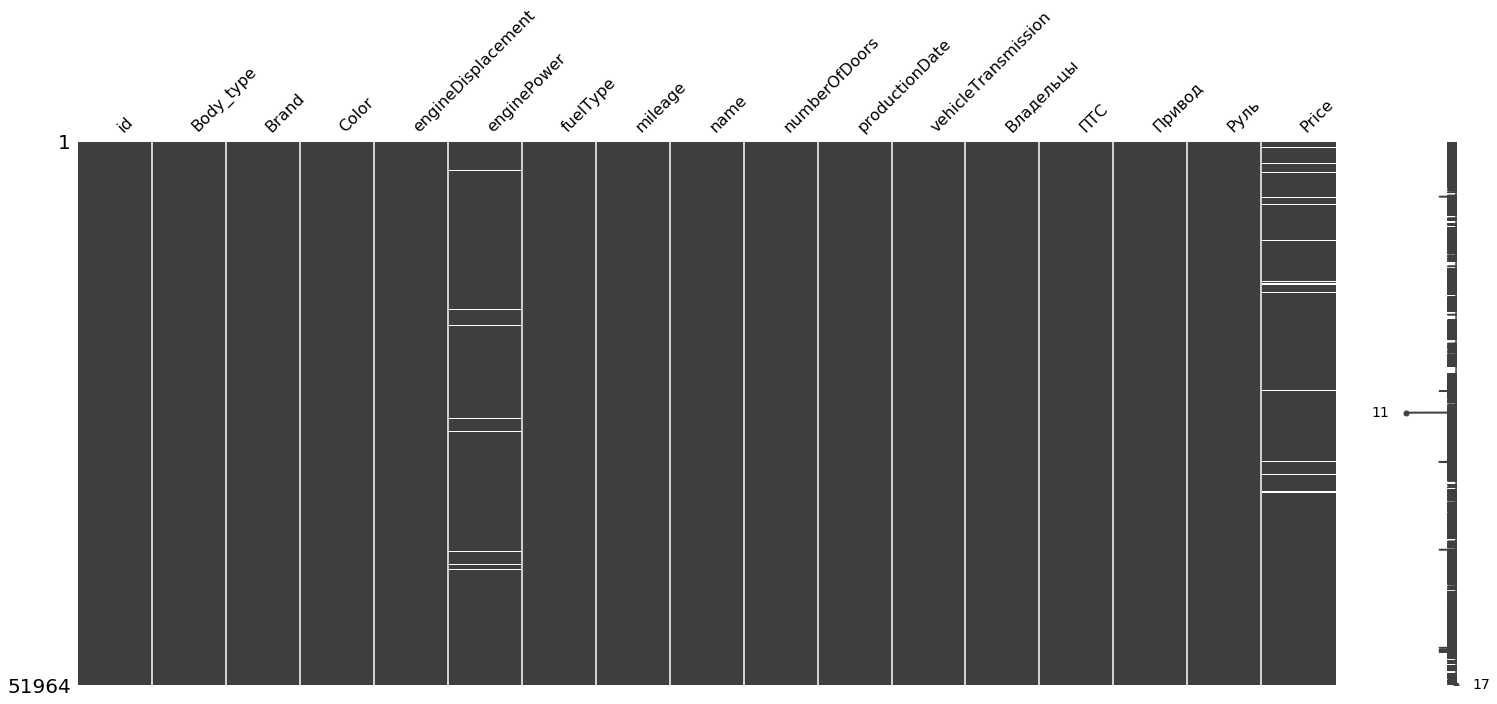

In [47]:
display(msno.matrix(df))
display(df.isnull().sum())

Пропусков у нас практически нет, они в основном в целевой переменной. Поскольку этот параметр для нас критичен, разумнее будет удалить их.

In [48]:
#df_qualitative = pd.DataFrame()
#df_quantitative = pd.DataFrame()
#df_binary = pd.DataFrame()
#df_nominative = pd.DataFrame()#


#    elif col in quantitative:
#        df_quantitative[col] = df[col]
#    elif col in binary:
#        df_binary[col] = df[col]
#    else:
#        df_nominative[col] = df[col]
#        nominative.append(col)

In [49]:
#binary = ['custom_cleared','pts','vin_resolution','steering_wheel_type']
#quantitative = ['mileage','trunk_volume_min','engine_power','year']
#nominative = ['brand','model','color_code','region','tip_auto','Count_doors','class_auto','fuel_type',
#             'transmission','gear_type','owners_number']

In [70]:
train = df # мой подготовленный датасет для обучения модели
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

## Data Preprocessing

In [71]:
# 1. Удалить пропуски
# 2. Перевести часть фичей в int32
# 3. Сравнять признаки engineDisplacement и enginePower в train и test

id                        0
Body_type                 1
Brand                     0
Color                     0
engineDisplacement        0
enginePower             881
fuelType                  1
mileage                   0
name                      0
numberOfDoors             1
productionDate            0
vehicleTransmission       1
Владельцы                 4
ПТС                       0
Привод                    1
Руль                      0
Price                  1014
dtype: int64

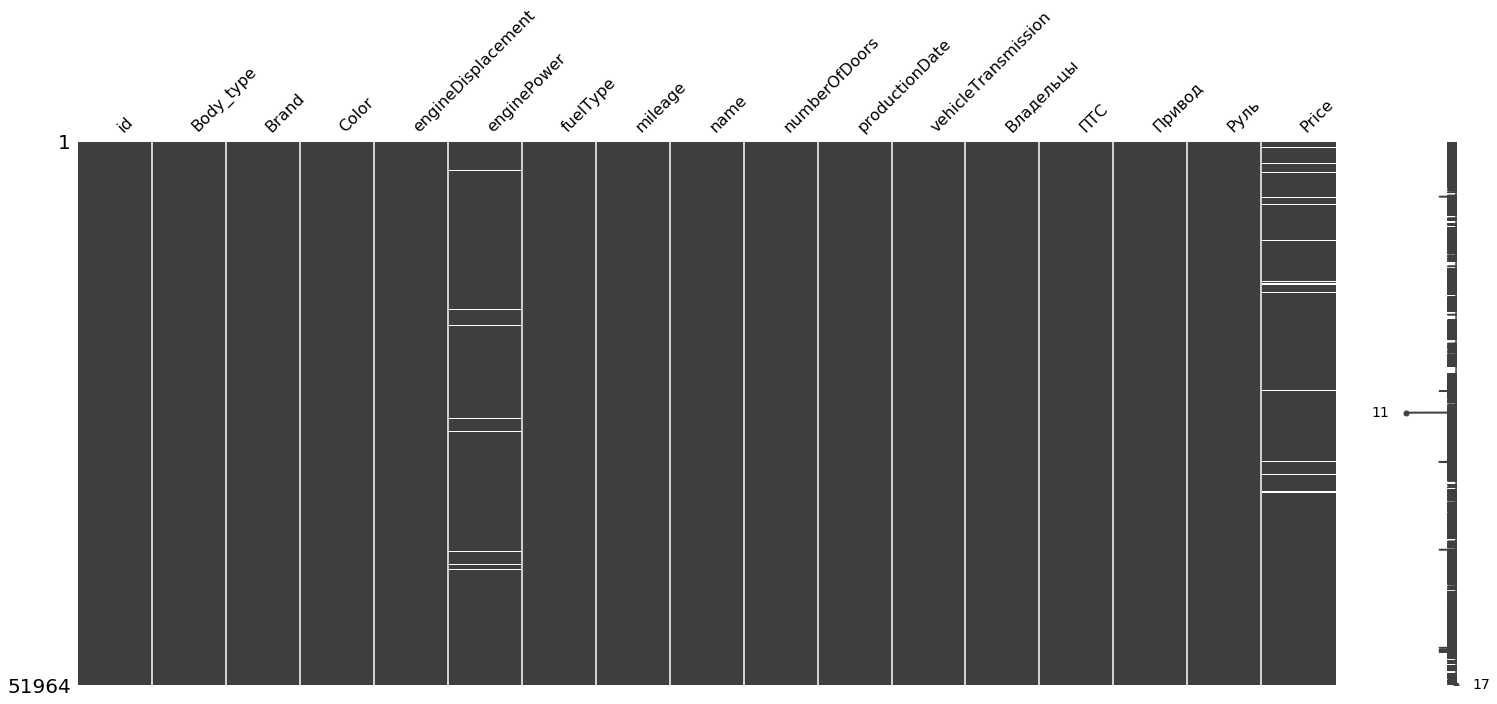

In [72]:
# Сперва оценим датасет на предмет пропусков

display(msno.matrix(df))
display(df.isnull().sum())

Пропусков у нас практически нет, они в основном в целевой переменной. Поскольку этот параметр для нас критичен, разумнее будет удалить их.

In [73]:
train = train.dropna()

In [74]:
for feature in ['numberOfDoors', 'mileage', 'productionDate']:
    train[feature]=train[feature].astype('int32')
for feature in ['numberOfDoors', 'mileage', 'productionDate']:
    test[feature]=test[feature].astype('int32')


E:\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [117]:
# Обработаем признак engineDisplacement
train.engineDisplacement = train.engineDisplacement.apply(lambda x: x.replace(x[:3]))

TypeError: replace() takes at least 2 arguments (1 given)

In [77]:
test.drop(['car_url',
           'complectation_dict',
           'description',
           'equipment_dict',
           'image',
           'modelDate',
           'parsing_unixtime',
           'priceCurrency',
           'sell_id',
           'super_gen',
           'vehicleConfiguration',
           'vendor',
           'Владение',
           'Состояние',
           'Таможня',
           'model_info',
           'model_name'], inplace=True, axis=1)

In [81]:
train.drop(['id'], inplace=True, axis=1)

E:\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [90]:
X = train.drop('Price', axis=1)
y = train.Price.values

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [99]:
cat_features_ids = np.where(X_train.apply(pd.Series.nunique) < 3000)[0].tolist()

In [100]:
model = CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = LR,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE']
                         )
model.fit(X_train, y_train,
         cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=3]="2.7 MT (128 л.с.), внедорожник, полный, бензин": Cannot convert 'b'2.7\xc2\xa0MT (128\xc2\xa0\xd0\xbb.\xd1\x81.), \xd0\xb2\xd0\xbd\xd0\xb5\xd0\xb4\xd0\xbe\xd1\x80\xd0\xbe\xd0\xb6\xd0\xbd\xd0\xb8\xd0\xba, \xd0\xbf\xd0\xbe\xd0\xbb\xd0\xbd\xd1\x8b\xd0\xb9, \xd0\xb1\xd0\xb5\xd0\xbd\xd0\xb7\xd0\xb8\xd0\xbd'' to float

In [ ]:
model.save_model('catboost_single_model_baseline.model')

In [ ]:
predict_submission = model.predict(X_sub)
predict_submission

In [ ]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_v{VERSION}.csv', index=False)
sample_submission.head(10)